In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

In [3]:
def staticSampling(ntype, d, npoints, graph, animyes): #Type of LH, space dimension d, number of points p, option to graph 2d/3d plots
    p = npoints
    def fullrandom(p):                       #Uniformly spread randomized points
        matrix = np.zeros((d,p))    #Matrix with dimensions-rows and points-columns
        for j in range(p):
            matrix[:,j] = np.random.uniform(low=0, high=1, size=d)
        return matrix

    def fullfactorial(p):           #The given p is the number of divisions along the first dimension, the true number of points is (p+d-1)!/(d-1)!
        pd = p*1
        p = pd*1
        matrix = np.array([range(pd)])/(pd-1)
        for i in range(1,d):
            pd = pd+1
            p = p*pd
            matrixtemp = matrix*1
            matrix = np.concatenate((matrix, np.zeros((1,int(p/pd)))), axis=0)
            for j in range(1,pd):
                temp = np.concatenate((matrixtemp, np.ones((1,int(p/pd)))*j/(pd-1)), axis=0)
                matrix = np.concatenate((matrix, temp), axis=1)
        print(str(p)+' points')
        return matrix, p


    def LS(p):                        #Latin sample divided in p partitions, and a point in the middle to illustrate them
        psize = 1/p
        matrix = np.zeros((d,p))
        for i in range(d): matrix[i,:] = np.random.choice(p, p, replace=False)
        return (np.ones_like(matrix)*0.5+matrix)*psize

    def LSoptim(p):                   #LS optimized through pairwise random permutations
        psize = 1/p
        matrix = LS(p)
        iters = int(p*2+800)

        FFMpegWriter = manimation.writers['ffmpeg']
        metadata = dict(artist='Pablo A.C.')
        writer = FFMpegWriter(fps=15, metadata=metadata)
        fig = plt.figure()

        with writer.saving(fig, 'LSoptim.mp4', iters):
            for k in range(iters):
                if k % 10 == 0: 
                    #print('LSoptim iter nº: '+str(k))
                    if animyes==True:
                        ax = plotting2D(matrix, p)
                        writer.grab_frame()
                        ax.clear()

                points = np.random.choice(p,2,replace=False)
                dim = np.random.choice(d,1,replace=False)[0]
                temp = matrix[dim,points[0]]

                phiold = phip_reduced(matrix, p, points[0], points[1])
                matrix[dim,points[0]] = matrix[dim,points[1]]
                matrix[dim,points[1]] = temp
                phinew = phip_reduced(matrix, p, points[0], points[1])
                if phinew>phiold:
                    matrix[dim,points[1]] = matrix[dim,points[0]]
                    matrix[dim,points[0]] = temp
        return matrix

    def LHS(p):                               #LS with random points inside the partitions
        psize = 1/p
        matrix = LS(p)
        return np.random.uniform(low=matrix-0.1*psize*np.ones_like(matrix), high=matrix+0.1*psize*np.ones_like(matrix), size=(d,p))

    def LHSoptim(p):                          #LSoptim with random points inside the partitions
        psize = 1/p
        matrix = LSoptim(p)
        return np.random.uniform(low=matrix-0.1*psize*np.ones_like(matrix), high=matrix+0.1*psize*np.ones_like(matrix), size=(d,p))

    def SLHS(p):                               #Sliced Latin Hypercube Sample or Design, divided in T slices of LHS M partitions, resulting in t x m = p (points)
        T = 3 #Levels of the categorical variable, nº of slices
        M = 4 #Points per slice
        p = M*T
        psize = 1/p
        X = {}
        matrix = np.zeros((d,p))
        for t in range(T):
            X[t] = np.zeros((d,M),dtype=int)
            for i in range(d): X[t][i,:] = np.random.choice(M, M, replace=False)
        for i in range(d):
            for m in range(M):
                temp = np.random.choice(np.arange(m*T,m*T+T),T,replace=False)
                for t in range(T):
                    index = np.where(X[t][i,:]==m)[0][0]
                    matrix[i,index+M*t] = temp[t]
        return np.random.uniform(low=psize*matrix, high=psize*matrix+psize*np.ones_like(matrix), size=(d,p))

    def TPLHS(p):                              #Translational Propagation Latin Hypercube Sample or Design
        nb = 2**d               #Number of blocks
        pb = int(np.ceil(p/nb)) #Number of points per block
        mp = int(pb*nb)         #Number of points before trimming the design to match p points

        if pb>1: seedl = LSoptim(int(pb))
        elif pb==1: seedl = 0.5*np.ones((d,1))
        X = seedl*(mp/2)-np.ones_like(seedl)

        for i in range(d):      #Construction of the LH
            temp = X[:,:] + np.ones_like(X)
            temp[i,:] = temp[i,:] + (mp/2-1)*np.ones_like(temp[i,:])
            X = np.concatenate((X, temp), axis=1)            

        for k in range(mp-p):   #Reducing and scaling to p points
            index = np.where(X[0,:]==np.amax(X[0,:]))[0][0]
            for i in range(d):
                for j in range(len(X[i,:])):
                    if j==index: continue
                    elif X[i,j]>X[i,index]: X[i,j] = X[i,j]-1
            X = np.delete(X, index, axis=1)
        return X*(1/(p-1))

    def iter_maximin(p):                       #Maximin design by iteration
        psize = 1/p
        matrix = fullrandom(p)
        iters = 150
        critmin = 1/p**(1/d)
        a = 1/iters*np.log(0.0001/0.1)

        FFMpegWriter = manimation.writers['ffmpeg']
        metadata = dict(artist='Pablo A.C.')
        writer = FFMpegWriter(fps=15, metadata=metadata)
        fig = plt.figure()

        with writer.saving(fig, 'Pseudomaximin.mp4', iters):
            for k in range(iters):
                if k % 10 == 0: 
                    criteria = mindist(matrix, p)
                    #if criteria>critmin: break
                    print('iter_maximin iter nº: '+str(k))
                step = 0.1*np.exp(a*k)                
                if animyes==True:
                    ax = plotting2D(matrix, p)
                    writer.grab_frame()
                    ax.clear()

                for i in range(p):
                    dold = d
                    point = matrix[:,i]
                    for j in range(p):
                        if i==j: continue
                        dnew = np.sum((point-matrix[:,j])**2)
                        if dnew<dold:
                            dold = dnew
                            index = j
                    if distancetowall(point)<psize:
                        matrix[:,i] = (1-step)*point+0.5*step*np.ones(d)
                        continue
                    matrix[:,i] = (1+step)*point-step*matrix[:,index]  
        return matrix

    def plotting2D(matrix, p):
        ax = plt.axes()
        ax.plot([0,1,1,0,0],[0,0,1,1,0], color='k')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        if p<13:
            for j in range(1,p):
                k = j/p
                ax.plot([k,k],[0,1], color='b', linestyle='--')
                ax.plot([0,1],[k,k], color='b', linestyle='--')
        ax.scatter(matrix[0,:], matrix[1,:])
        return ax

    def plotting3D(matrix, p):
        ax = plt.axes(projection='3d')
        if p<9:
            ax.grid(False)
            for j in range(1,p):
                k = j/p
                ax.plot3D([k,k],[0,1],[0,0], color='b', linestyle='--')
                ax.plot3D([0,1],[k,k],[0,0], color='b', linestyle='--')
                ax.plot3D([0,0],[0,1],[k,k], color='b', linestyle='--')
                ax.plot3D([0,0],[k,k],[0,1], color='b', linestyle='--')
                ax.plot3D([k,k],[1,1],[0,1], color='b', linestyle='--')
                ax.plot3D([0,1],[1,1],[k,k], color='b', linestyle='--')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.plot3D([0,1,1,0,0,0,1,1,0,0],[0,0,1,1,0,0,0,1,1,0],[0,0,0,0,0,1,1,1,1,1], color='k')
        ax.plot3D([1,1,1,1,0,0],[0,0,1,1,1,1],[0,1,1,0,0,1], color='k')
        ax.scatter(matrix[0,:], matrix[1,:], matrix[2,:], marker='o', s=20)
        return ax

    def d1score(matrix, p):                     #Minimum distance between the projection of the points along every dimension compared to the maximum possibly obtained
        maxscore = 1/(p-1)                      #This equals to the distance between pairs of p equally spaced points from [0 to 1]
        k_old = 3
        for i in range(d):
            for k1 in range(p-1):
                for k2 in range(k1+1,p):
                    k = np.abs(matrix[i,k1]-matrix[i,k2])
                    if k<k_old: k_old = k
        return k_old/maxscore*100
    
    def mindist(matrix, p):                     #Minimum distance between two points
        k_old = 3
        for i in range(p-1):
            for j in range(i+1,p):
                k = np.sum((matrix[:,i]-matrix[:,j])**2)**0.5
                if k<k_old: k_old = k
        return k_old

    def phip(matrix, p):
        if p>160: 
            phi = 1/mindist(matrix, p)          #For very large values of p, we can't compute phi but it's equal to 1/mindist in the limit
            return phi
        phi = 0
        for i in range(p-1):
            for j in range(i+1,p):
                phi += np.sum((matrix[:,i]-matrix[:,j])**2)**(-0.5*p)
        phi = phi**(1/p)
        return phi
   

    def phip_reduced(matrix, p, index1, index2):
        if p>160:                               #For very large values of p, we can't compute phi but it's equal to 1/mindist in the limit
            k_old = np.sqrt(np.sum((matrix[:,index1]-matrix[:,index2])**2))
            for j in range(p):
                if j==index1 or j==index2: continue
                k = np.sum((matrix[:,index1]-matrix[:,j])**2)**0.5
                if k<k_old: k_old = k
                k = np.sum((matrix[:,index2]-matrix[:,j])**2)**0.5
                if k<k_old: k_old = k
            return 1/k_old

        phi = np.sum((matrix[:,index1]-matrix[:,index2])**2)**(-0.5*p)
        for j in range(p):
            if j==index1 or j==index2: continue
            phi += np.sum((matrix[:,index1]-matrix[:,j])**2)**(-0.5*p)
            phi += np.sum((matrix[:,index2]-matrix[:,j])**2)**(-0.5*p)
        phi = phi**(1/p)
        return phi

    def distancetowall(vector):
        dist0 = np.amin(vector)
        dist1 = np.amax(vector)
        return np.minimum(dist0, 1-dist1)


    if ntype=='fullrandom': matrix = fullrandom(p)
    elif ntype=='fullfactorial': matrix, p = fullfactorial(p)
    elif ntype=='LS': matrix = LS(p)
    elif ntype=='LSoptim': matrix = LSoptim(p)
    elif ntype=='LHS': matrix = LHS(p)
    elif ntype=='LHSoptim': matrix = LHSoptim(p)
    elif ntype=='SLHS': matrix = SLHS(p)
    elif ntype=='TPLHS': matrix = TPLHS(p)
    elif ntype=='iter_maximin': matrix = iter_maximin(p)
    else: print('Error, LHS method not found')
    plt.close()

    if graph==True:
        fig = plt.figure()
        if d==2: plotting2D(matrix, p)
        elif d==3: plotting3D(matrix, p)
        else: print('Cant plot - Dimension /= 2 or 3')
    
    score1 = mindist(matrix, p)
    print('Minimum distance, higher is better:')
    print(score1)
    score2 = phip(matrix, p)
    print('Phi_p criteria, lower is better')
    print(score2)
    score3 = d1score(matrix, p)
    print('1 dimensional score in %:')
    print(score3)

    return matrix, score2


Minimum distance, higher is better:
0.18976585660336784
Phi_p criteria, lower is better
5.683011975199559
1 dimensional score in %:
99.99999999999989
Wall time: 306 ms


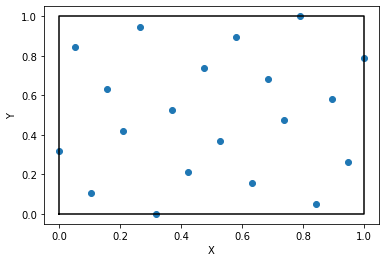

In [27]:
%%time
ndim = 2  
npart = 20

set1, phip1 = staticSampling('TPLHS',ndim,npart,True,False)

Minimum distance, higher is better:
0.007836501495457945
Phi_p criteria, lower is better
127.60796390833364
1 dimensional score in %:
99.99999999999025
Wall time: 23.5 s


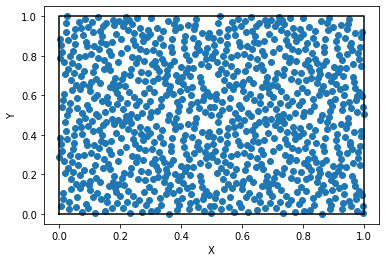

In [29]:
%%time
ndim = 2
npart = 930

set2, phip2 = staticSampling('TPLHS',ndim,npart,True,False)

In [60]:
%%time
ndim = 4
npart = 40

set3, phip3 = staticSampling('TPLHS',ndim,npart,True,False)
print(np.amax(set1))
print(np.amin(set1))

8
Dimension /= 2 or 3
Minimum distance, higher is better:
0.3263569759322527
Phi_p criteria, lower is better
3.165522057389297
1 dimensional score in %:
0.0
1.0
0.0
Wall time: 269 ms


<Figure size 432x288 with 0 Axes>